In [1]:
import os
import torch
import pickle
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import cv2
from torchvision import models
from sklearn import preprocessing
from tqdm import tqdm
import random
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
from transformers import AutoImageProcessor, ViTForImageClassification
import torch
from datasets import load_dataset

In [3]:
ls /kaggle/input/

indices/  mobilenet/  resnet50-final/  stanford-dogs-dataset/


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
dataset = datasets.ImageFolder('/kaggle/input/stanford-dogs-dataset/images/Images')
dataset_len = len(dataset)

In [8]:
def load_text_file(path):
        with open(path, 'r') as f:
            text = f.read()
        return text

In [9]:
annotation = datasets.DatasetFolder('/kaggle/input/stanford-dogs-dataset/annotations/Annotation', loader=load_text_file, extensions=('',))

In [10]:
train_size = int(dataset_len*0.7)
test_size = int(dataset_len*0.1)
val_size = int(dataset_len*0.2)

In [11]:
def train_test_val_split():
  g = torch.Generator()
  g.manual_seed(42)
  indices = list(range(dataset_len))
  np.random.seed(11)
  np.random.shuffle(indices)

  test_index = indices[:test_size]
  train_index = indices[test_size:test_size+train_size]
  val_index = indices[-val_size:]

  train_sampler=SubsetRandomSampler(train_index, generator=g)
  val_sampler=SubsetRandomSampler(val_index, generator=g)
  test_sampler=SubsetRandomSampler(test_index, generator=g)

  return train_sampler,val_sampler,test_sampler,indices, train_index

In [12]:
train_sampler,val_sampler,test_sampler,indices, train_index = train_test_val_split()

In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset, annotation, train_index, transform=None, normalize=None):
        self.dataset = dataset
        self.annotation = annotation
        self.dataset_len = len(dataset)
        self.transform = transform
        self.normalize = normalize
        self.train_index = train_index
        # self.dataset = np.transpose(dataset[0], (1, 2, 0))        

    def __len__(self):
        return self.dataset_len
    
    def load_text_file(path):
        with open(path, 'r') as f:
            text = f.read()
        return text

    def __getitem__(self, idx):
        
        image, index = self.dataset[idx]
        w,h = image.size
        
        if (idx in self.train_index):
            text = annotation[idx][0]

            xml_root = ET.fromstring(text)
            
            width = int(xml_root.find('size/width').text)
            height = int(xml_root.find('size/height').text)
            xmin = int(xml_root.find('object/bndbox/xmin').text)
            xmax = int(xml_root.find('object/bndbox/xmax').text)
            ymin = int(xml_root.find('object/bndbox/ymin').text)
            ymax = int(xml_root.find('object/bndbox/ymax').text)
            
            bbox = (xmin, ymin, xmax, ymax)

            annotated_image = Image.new("RGB", (width, height), color=(255, 255, 255))

            annotated_image.paste(image, (0, 0))

            draw = ImageDraw.Draw(annotated_image)
            thickness = 5
            draw.rectangle(bbox, outline="red", width=thickness)
            
            image = annotated_image
            plt.imshow(image)
            
        
        if w < h:
            resized_image = image.resize((224, int(224 * h / w)))
        else:
            resized_image = image.resize((int(224 * w / h), 224))
        w,h = resized_image.size
        image = resized_image.crop((w/2  - 112, h/2 - 112, w/2 + 112, h/2 + 112))
        if self.transform:
            image = self.transform(image)
            image = image.to(torch.float32)
            image = image/255
            image = self.normalize(image)

        label = index

        return image, label

In [14]:
normalize = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
 ])

In [15]:
transform = transforms.Compose([
    transforms.PILToTensor(),
#     transforms.Resize((224, 224)), 
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomRotation(degrees = (0,20)),
    # transforms.GaussianBlur(5),
])

In [16]:
ImageDataset = CustomImageDataset(dataset,annotation,train_index, transform, normalize)

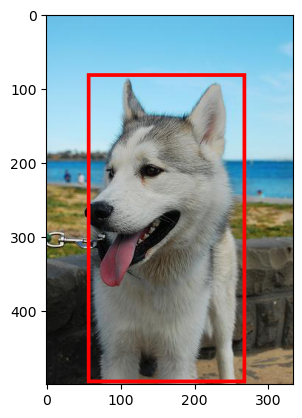

In [17]:
i,l = ImageDataset[train_index[12]]

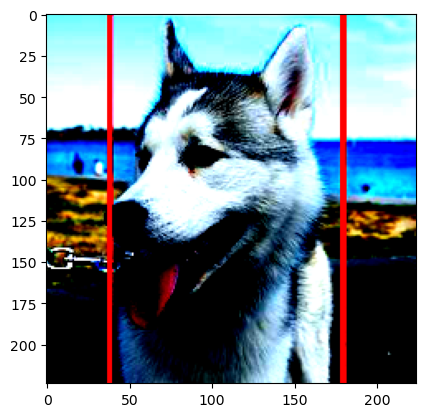

In [18]:
plt.imshow(i.permute(1,2,0))

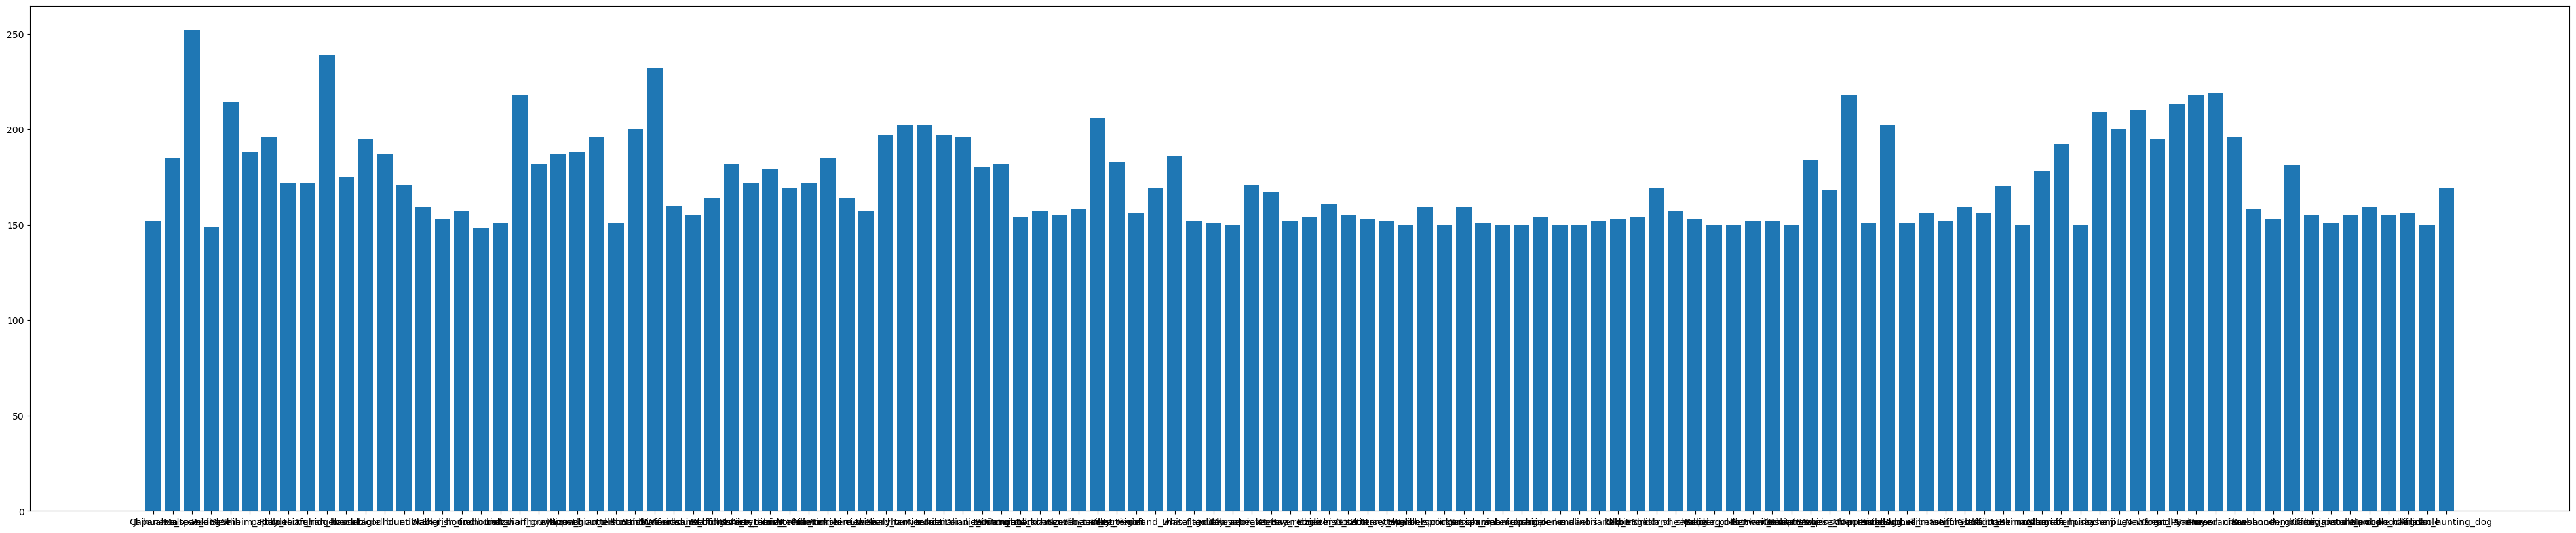

In [20]:
plt.figure(figsize=(50,10))
plt.bar(range(len(labels_list)), labels_list, tick_label=labels_names)

plt.show()

In [26]:
batch_size=32
trainloader = torch.utils.data.DataLoader(ImageDataset, sampler = train_sampler, batch_size=batch_size)
valloader = torch.utils.data.DataLoader(ImageDataset, sampler = val_sampler, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(ImageDataset, sampler = test_sampler, batch_size=batch_size)

In [27]:
def accuracy_test(model,loader,criterion):
  correct = 0
  total = 0
  tot_loss = 0
  with torch.no_grad():
      for data in loader:
          images, labels = data
                    
          images = images.float().to(device)
          # labels = labels.float().to(device)

          le = preprocessing.LabelEncoder()
          targets = le.fit_transform(labels)
          targets = torch.as_tensor(targets) 
            
#           inputs = image_processor(images, return_tensors="pt")
          outputs = model(images)
#           outputs = outputs.to(device)
          
          _, predicted = torch.max(outputs.logits, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          labels = labels.to(device)
          correct += (predicted == labels).sum().item()
          
          # outputs = outputs.argmax(1).to(torch.float64)
          labels = labels.to(torch.int64)
          labels = F.one_hot(labels, num_classes=120).to(torch.float64)

          loss = criterion(outputs.logits, torch.max(labels, 1)[1])
#           loss.requires_grad = True
#           loss.backward()
          tot_loss += loss.item()


  Accuracy = 100 * correct / total
  Loss = tot_loss / total
  return Accuracy,Loss


In [28]:
def training(model,loader,criterion,optimizer,config,valloader):
  train_acc_arr = []
  train_loss_arr = []
  val_acc_arr = []
  val_loss_arr = []
  y_pred = []
  y_true = []

  for epoch in tqdm(range(config['epochs'])):

    example_ct = 0
    batch_ct = 0
    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data

        labels_without_one_hot = labels.float().to(device)
        labels = F.one_hot(labels, num_classes=120)
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

#         inputs = image_processor(inputs, return_tensors="pt")
        # labels = labels.argmax(1).to(torch.float64)
        outputs = model(inputs)

        # outputs = torch.argmax(outputs ,axis=1)
        _, predicted = torch.max(outputs.logits, 1)

        total += labels.size(0)
        correct += (predicted == labels_without_one_hot).sum().item()

        loss = criterion(outputs.logits, torch.max(labels, 1)[1])
        optimizer.zero_grad()
        # loss.requires_grad = True
        loss.backward()
        optimizer.step()

        example_ct +=  len(inputs)
        batch_ct += 1
        running_loss += loss.item()

        if ((batch_ct) % 100) == 0:
            print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")
            print(f"Training Accuracy: {100*correct/total}")

    # train_acc, train_loss = accuracy_test(model,trainloader,criterion)
    train_acc = 100*correct/total
    train_loss = running_loss/total
    val_acc,val_loss = accuracy_test(model,valloader,criterion)
    print()
    print("VALIDATION ACC",val_acc)
    print("VALIDATION LOSS",val_loss)
    print()
    train_acc_arr.append(train_acc)
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    val_loss_arr.append(val_loss)

  print("Finished training")
  return train_acc_arr,train_loss_arr,val_acc_arr,val_loss_arr

In [29]:
def test(model, loader):
    model.eval()

    correct, total ,incorrect= 0, 0,0

    y_pred = []
    y_true = []

    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    with torch.no_grad():
        for data in loader:
          images, labels = data

          saved_images = images

          images = images.float().to(device)
          # images = torch.transpose(images,-1,1)
          labels = labels.float().to(device)
        
#           inputs = image_processor(images, return_tensors="pt")
            
          outputs = model(images)
#           outputs = outputs.to(device)

          _, predicted = torch.max(outputs.logits, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          correct += (predicted == labels).sum().item()

          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())
          
          # labels = labels.to(torch.int64)
          # labels = F.one_hot(labels, num_classes=10).to(torch.float64)

          # loss = criterion(outputs, labels)
          # loss.requires_grad = True
          # loss.backward()
          # tot_loss += loss.item()

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
    print(classification_report(y_true, y_pred))
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Accuracy of the model on the set of " + f"test images: {correct / total:%}")

    return y_true, y_pred

In [31]:
class MobileNetV2(nn.Module):

    def __init__(self, dropout=0.3):

        super(MobileNetV2, self).__init__()

        self.mobile = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=models.mobilenetv2.MobileNet_V2_Weights.DEFAULT)
        self.mobile.classifier[1] = nn.Linear(1280,120)
#         self.dropout = nn.Dropout(dropout)
#         self.linear = nn.Linear(1000, 120)
#         self.soft = nn.Softmax()

    def forward(self, images):

        pooled_output = self.mobile(images)

#         dropout_output = self.dropout(pooled_output)
#         linear_output = self.linear(dropout_output)
#         final_layer = self.soft(pooled_output)

        return pooled_output

In [32]:
class RESNET50(nn.Module):

    def __init__(self, dropout=0.3):

        super(RESNET50, self).__init__()

        self.mobile = models.resnet50(pretrained=True)
        self.mobile.fc = nn.Linear(2048, 120)

    def forward(self, images):

        pooled_output = self.mobile(images)

        return pooled_output

In [33]:
class VITMODEL(nn.Module):

    def __init__(self, dropout=0.3):

        super(VITMODEL, self).__init__()

        self.vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
#         self.dropout = nn.Dropout(dropout)
#         self.linear = nn.Linear(768, 120)
        self.vit.classifier = nn.Linear(768,120)
        

    def forward(self, images):
            
        pooled_output = self.vit(images)
#         print(pooled_output.shape)
#         print(pooled_output)
#         pooled_output = pooled_output.logits
#         print(pooled_output)
#         dropout_output = self.dropout(pooled_output)
#         linear_output = self.linear(dropout_output)

        return pooled_output

In [34]:
def model_pipeline(hyperparameters, trainloader, valloader, testloader, residual):
    

#   model = VITMODEL().to(device)
  model = MobileNetV2().to(device)
#   model = RESNET50().to(device)

  criterion = nn.CrossEntropyLoss()
#   optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum = 0.9)
  optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

  # and use them to train the model
  train_acc,train_loss,val_acc,val_loss = training(model, trainloader, criterion, optimizer, config, valloader)


  # and test its final performance
  test_true, test_pred = test(model, testloader)


  print("FINISHED")

  return test_true, test_pred,train_acc,train_loss,val_acc,val_loss, model

In [35]:
config = dict(
    epochs=10,
    classes=120,
    batch_size=128,
    learning_rate=0.0001,
    dataset="MNIST",
    architecture="CNN")

  0%|          | 0/10 [00:00<?, ?it/s]

Loss after 03200 examples: 4.329
Training Accuracy: 2.625
Loss after 06400 examples: 4.037
Training Accuracy: 8.9375
Loss after 09600 examples: 3.541
Training Accuracy: 17.114583333333332
Loss after 12800 examples: 3.162
Training Accuracy: 26.140625


 10%|█         | 1/10 [08:29<1:16:29, 509.92s/it]


VALIDATION ACC 63.72691933916424
VALIDATION LOSS 0.08690272632215183

Loss after 03200 examples: 2.441
Training Accuracy: 71.78125
Loss after 06400 examples: 2.225
Training Accuracy: 73.875
Loss after 09600 examples: 1.805
Training Accuracy: 75.85416666666667
Loss after 12800 examples: 1.489
Training Accuracy: 77.1171875


 20%|██        | 2/10 [15:34<1:01:19, 459.90s/it]


VALIDATION ACC 82.11856171039844
VALIDATION LOSS 0.04443907911506408

Loss after 03200 examples: 1.047
Training Accuracy: 87.9375
Loss after 06400 examples: 1.017
Training Accuracy: 88.203125
Loss after 09600 examples: 0.771
Training Accuracy: 88.58333333333333
Loss after 12800 examples: 0.699
Training Accuracy: 88.8125


 30%|███       | 3/10 [22:35<51:34, 442.01s/it]  


VALIDATION ACC 85.47133138969873
VALIDATION LOSS 0.028116529577559238

Loss after 03200 examples: 0.419
Training Accuracy: 93.4375
Loss after 06400 examples: 0.501
Training Accuracy: 93.625
Loss after 09600 examples: 0.545
Training Accuracy: 93.46875
Loss after 12800 examples: 0.391
Training Accuracy: 93.375


 40%|████      | 4/10 [29:35<43:20, 433.35s/it]


VALIDATION ACC 86.71039844509232
VALIDATION LOSS 0.021648312173964793

Loss after 03200 examples: 0.523
Training Accuracy: 95.75
Loss after 06400 examples: 0.364
Training Accuracy: 96.015625
Loss after 09600 examples: 0.336
Training Accuracy: 96.25
Loss after 12800 examples: 0.299
Training Accuracy: 96.0859375


 50%|█████     | 5/10 [36:35<35:41, 428.33s/it]


VALIDATION ACC 87.0262390670554
VALIDATION LOSS 0.018574463618073914

Loss after 03200 examples: 0.238
Training Accuracy: 97.71875
Loss after 06400 examples: 0.519
Training Accuracy: 97.78125
Loss after 09600 examples: 0.214
Training Accuracy: 97.65625
Loss after 12800 examples: 0.191
Training Accuracy: 97.5859375


 60%|██████    | 6/10 [43:35<28:22, 425.51s/it]


VALIDATION ACC 86.34596695821186
VALIDATION LOSS 0.017436134767428085

Loss after 03200 examples: 0.150
Training Accuracy: 98.4375
Loss after 06400 examples: 0.073
Training Accuracy: 98.578125
Loss after 09600 examples: 0.155
Training Accuracy: 98.5
Loss after 12800 examples: 0.073
Training Accuracy: 98.546875


 70%|███████   | 7/10 [50:34<21:10, 423.40s/it]


VALIDATION ACC 86.56462585034014
VALIDATION LOSS 0.01664216069557113

Loss after 03200 examples: 0.175
Training Accuracy: 99.21875
Loss after 06400 examples: 0.075
Training Accuracy: 99.3125
Loss after 09600 examples: 0.081
Training Accuracy: 99.26041666666667
Loss after 12800 examples: 0.184
Training Accuracy: 99.1640625


 80%|████████  | 8/10 [57:34<14:04, 422.31s/it]


VALIDATION ACC 86.03012633624878
VALIDATION LOSS 0.0165290284224861

Loss after 03200 examples: 0.050
Training Accuracy: 99.59375
Loss after 06400 examples: 0.056
Training Accuracy: 99.546875
Loss after 09600 examples: 0.035
Training Accuracy: 99.5
Loss after 12800 examples: 0.048
Training Accuracy: 99.46875


 90%|█████████ | 9/10 [1:04:40<07:03, 423.56s/it]


VALIDATION ACC 85.8600583090379
VALIDATION LOSS 0.016351857382815017

Loss after 03200 examples: 0.035
Training Accuracy: 99.75
Loss after 06400 examples: 0.147
Training Accuracy: 99.703125
Loss after 09600 examples: 0.033
Training Accuracy: 99.6875
Loss after 12800 examples: 0.028
Training Accuracy: 99.6953125


100%|██████████| 10/10 [1:11:40<00:00, 430.03s/it]


VALIDATION ACC 86.00583090379008
VALIDATION LOSS 0.01624280350795061

Finished training


              precision    recall  f1-score   support

         0.0       0.67      0.80      0.73        10
         1.0       0.86      0.86      0.86        14
         2.0       0.76      0.90      0.83        21
         3.0       1.00      0.82      0.90        17
         4.0       0.80      0.87      0.83        23
         5.0       0.94      1.00      0.97        17
         6.0       1.00      0.94      0.97        18
         7.0       0.93      0.81      0.87        16
         8.0       0.83      0.91      0.87        22
         9.0       1.00      0.96      0.98        27
        10.0       1.00      0.95      0.98        22
        11.0       0.83      1.00      0.90        19
        12.0       0.83      0.94      0.88        16
        13.0       0.82      0.78      0.80        18
        14.0       0.94      0.88      0.91        17
        15.0       0.39      0.64      0.48        11
        16.0       0.50      0.29      0.36        14
        17.0       0.85    

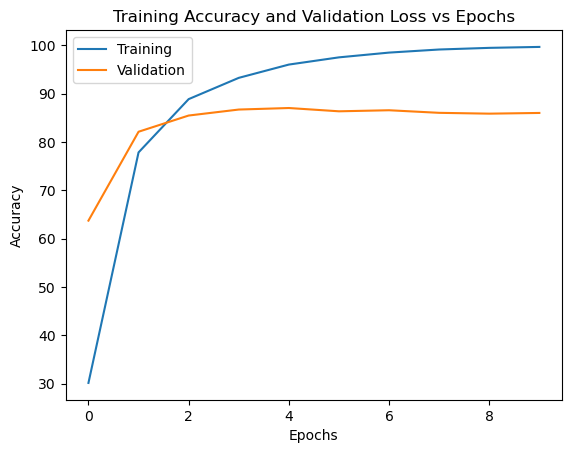

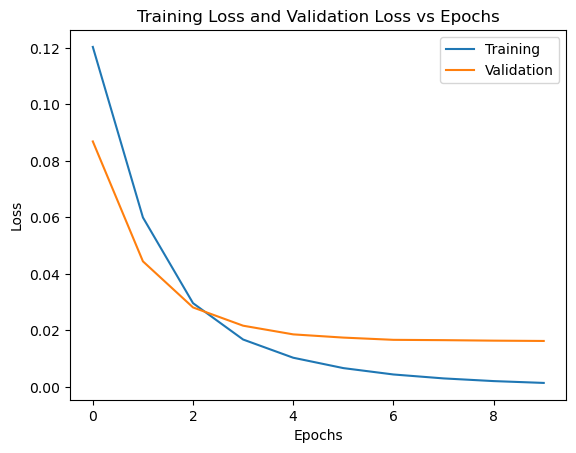

In [28]:
#ViT 1e-5 unbounded
test_true, test_pred ,train_acc,train_loss,val_acc,val_loss, model = model_pipeline(config, trainloader, valloader, testloader, False)
x = range(config["epochs"])
plt.plot(x,train_acc,label="Training")
plt.plot(x,val_acc,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy and Validation Loss vs Epochs")
plt.show()
x = range(config["epochs"])
plt.plot(x,train_loss,label="Training")
plt.plot(x,val_loss,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss and Validation Loss vs Epochs")
plt.show()
filename = '/resnet50'
pickle.dump(model, open(filename, 'wb'))

In [29]:
%cd /kaggle/working

/kaggle/working


In [30]:
filename = 'ViT_normal'
pickle.dump(model, open(filename, 'wb'))

In [31]:
from IPython.display import FileLink
FileLink(r'ViT_normal')

/kaggle/working/ViT_normal

In [51]:
criterion = nn.CrossEntropyLoss()
#   optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

# and use them to train the model
train_acc,train_loss,val_acc,val_loss = training(model, trainloader, criterion, optimizer, config, valloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Loss after 03200 examples: 0.161
Training Accuracy: 97.84375
Loss after 06400 examples: 0.269
Training Accuracy: 97.703125
Loss after 09600 examples: 0.093
Training Accuracy: 97.66666666666667
Loss after 12800 examples: 0.171
Training Accuracy: 97.59375


 20%|██        | 1/5 [07:19<29:17, 439.27s/it]


VALIDATION ACC 87.53644314868805
VALIDATION LOSS 0.0168948890849499

Loss after 03200 examples: 0.310
Training Accuracy: 98.875
Loss after 06400 examples: 0.061
Training Accuracy: 98.96875
Loss after 09600 examples: 0.254
Training Accuracy: 98.95833333333333
Loss after 12800 examples: 0.068
Training Accuracy: 98.953125


 40%|████      | 2/5 [14:37<21:55, 438.38s/it]


VALIDATION ACC 86.71039844509232
VALIDATION LOSS 0.016195705533389677

Loss after 03200 examples: 0.052
Training Accuracy: 99.46875
Loss after 06400 examples: 0.052
Training Accuracy: 99.34375
Loss after 09600 examples: 0.193
Training Accuracy: 99.42708333333333
Loss after 12800 examples: 0.045
Training Accuracy: 99.3984375


 60%|██████    | 3/5 [21:53<14:35, 437.67s/it]


VALIDATION ACC 87.07482993197279
VALIDATION LOSS 0.01548031513353826

Loss after 03200 examples: 0.027
Training Accuracy: 99.71875
Loss after 06400 examples: 0.026
Training Accuracy: 99.71875
Loss after 09600 examples: 0.027
Training Accuracy: 99.72916666666667
Loss after 12800 examples: 0.017
Training Accuracy: 99.6953125


 80%|████████  | 4/5 [29:11<07:17, 437.66s/it]


VALIDATION ACC 87.0019436345967
VALIDATION LOSS 0.015414829265445731

Loss after 03200 examples: 0.021
Training Accuracy: 99.84375
Loss after 06400 examples: 0.020
Training Accuracy: 99.84375
Loss after 09600 examples: 0.013
Training Accuracy: 99.83333333333333
Loss after 12800 examples: 0.012
Training Accuracy: 99.8125


100%|██████████| 5/5 [36:28<00:00, 437.71s/it]


VALIDATION ACC 87.0019436345967
VALIDATION LOSS 0.015233311860073644

Finished training


In [52]:
test_true, test_pred = test(model, testloader)

              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82        10
         1.0       0.92      0.86      0.89        14
         2.0       0.83      0.95      0.89        21
         3.0       1.00      0.88      0.94        17
         4.0       0.87      0.87      0.87        23
         5.0       0.94      1.00      0.97        17
         6.0       1.00      0.94      0.97        18
         7.0       0.82      0.88      0.85        16
         8.0       0.84      0.95      0.89        22
         9.0       1.00      0.96      0.98        27
        10.0       1.00      0.95      0.98        22
        11.0       0.90      1.00      0.95        19
        12.0       0.88      0.94      0.91        16
        13.0       0.94      0.83      0.88        18
        14.0       0.93      0.76      0.84        17
        15.0       0.46      0.55      0.50        11
        16.0       0.62      0.57      0.59        14
        17.0       0.94    

  0%|          | 0/5 [00:00<?, ?it/s]

Loss after 03200 examples: 4.459
Training Accuracy: 2.59375
Loss after 06400 examples: 3.754
Training Accuracy: 9.234375
Loss after 09600 examples: 3.300
Training Accuracy: 19.03125
Loss after 12800 examples: 3.047
Training Accuracy: 28.671875


 20%|██        | 1/5 [08:07<32:30, 487.54s/it]


VALIDATION ACC 68.99902818270165
VALIDATION LOSS 0.0888093680404018

Loss after 03200 examples: 2.303
Training Accuracy: 76.4375
Loss after 06400 examples: 1.883
Training Accuracy: 78.171875
Loss after 09600 examples: 1.732
Training Accuracy: 79.57291666666667
Loss after 12800 examples: 1.496
Training Accuracy: 80.34375


 40%|████      | 2/5 [15:23<22:52, 457.49s/it]


VALIDATION ACC 83.86783284742468
VALIDATION LOSS 0.048490132401589635

Loss after 03200 examples: 1.030
Training Accuracy: 90.28125
Loss after 06400 examples: 0.810
Training Accuracy: 90.203125
Loss after 09600 examples: 0.745
Training Accuracy: 90.38541666666667
Loss after 12800 examples: 0.816
Training Accuracy: 90.2734375


 60%|██████    | 3/5 [22:40<14:56, 448.10s/it]


VALIDATION ACC 86.24878522837706
VALIDATION LOSS 0.03148493644273664

Loss after 03200 examples: 0.515
Training Accuracy: 94.40625
Loss after 06400 examples: 0.466
Training Accuracy: 94.5
Loss after 09600 examples: 0.448
Training Accuracy: 94.27083333333333
Loss after 12800 examples: 0.387
Training Accuracy: 94.203125


 80%|████████  | 4/5 [29:57<07:23, 443.69s/it]


VALIDATION ACC 87.14771622934889
VALIDATION LOSS 0.02383922945537882

Loss after 03200 examples: 0.295
Training Accuracy: 96.96875
Loss after 06400 examples: 0.316
Training Accuracy: 96.84375
Loss after 09600 examples: 0.460
Training Accuracy: 96.69791666666667
Loss after 12800 examples: 0.225
Training Accuracy: 96.5390625


100%|██████████| 5/5 [37:15<00:00, 447.02s/it]


VALIDATION ACC 87.56073858114675
VALIDATION LOSS 0.020440994085792898

Finished training


              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        10
         1.0       0.92      0.86      0.89        14
         2.0       0.95      0.90      0.93        21
         3.0       1.00      0.82      0.90        17
         4.0       0.84      0.91      0.87        23
         5.0       0.94      1.00      0.97        17
         6.0       1.00      0.94      0.97        18
         7.0       0.92      0.75      0.83        16
         8.0       0.86      0.86      0.86        22
         9.0       1.00      1.00      1.00        27
        10.0       1.00      1.00      1.00        22
        11.0       0.86      1.00      0.93        19
        12.0       0.94      0.94      0.94        16
        13.0       0.94      0.83      0.88        18
        14.0       1.00      0.71      0.83        17
        15.0       0.54      0.64      0.58        11
        16.0       0.64      0.50      0.56        14
        17.0       0.80    

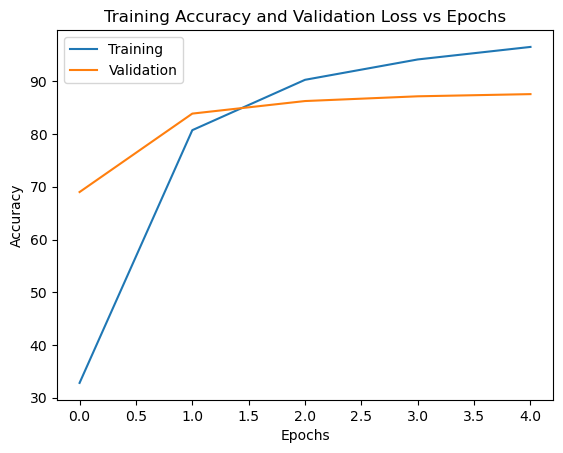

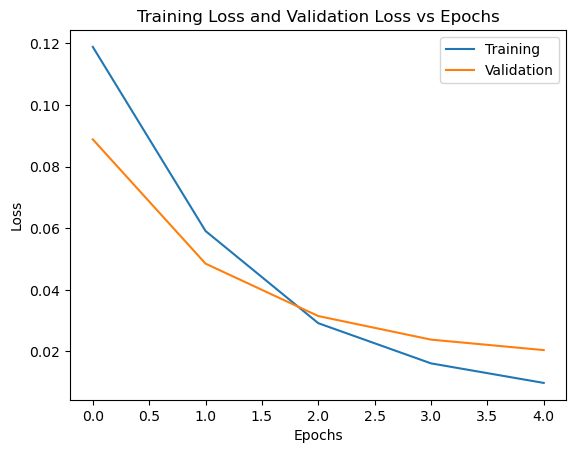

In [47]:
#ViT 1e-5 bounded
test_true, test_pred ,train_acc,train_loss,val_acc,val_loss, model = model_pipeline(config, trainloader, valloader, testloader, False)
x = range(config["epochs"])
plt.plot(x,train_acc,label="Training")
plt.plot(x,val_acc,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy and Validation Loss vs Epochs")
plt.show()
x = range(config["epochs"])
plt.plot(x,train_loss,label="Training")
plt.plot(x,val_loss,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss and Validation Loss vs Epochs")
plt.show()
filename = '/resnet50'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
!pip freeze > requirements.txt

In [70]:
def test_res(model, loader):
    model.eval()

    correct, total ,incorrect= 0, 0,0

    y_pred = []
    y_true = []

    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    with torch.no_grad():
        for data in loader:
          images, labels = data

          saved_images = images

          images = images.float().to(device)
          # images = torch.transpose(images,-1,1)
          labels = labels.float().to(device)
        
#           inputs = image_processor(images, return_tensors="pt")
            
          outputs = model(images)

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          correct += (predicted == labels).sum().item()

          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())
          

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
    print(classification_report(y_true, y_pred))
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Accuracy of the model on the set of " + f"test images: {correct / total:%}")

    return y_true, y_pred

In [71]:
def training_res(model,loader,criterion,optimizer,config,valloader):
  train_acc_arr = []
  train_loss_arr = []
  val_acc_arr = []
  val_loss_arr = []
  y_pred = []
  y_true = []

  for epoch in tqdm(range(config['epochs'])):

    example_ct = 0
    batch_ct = 0
    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data

        labels_without_one_hot = labels.float().to(device)
        labels = F.one_hot(labels, num_classes=120)
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels_without_one_hot).sum().item()

        loss = criterion(outputs, torch.max(labels, 1)[1])
        optimizer.zero_grad()
        # loss.requires_grad = True
        loss.backward()
        optimizer.step()

        example_ct +=  len(inputs)
        batch_ct += 1
        running_loss += loss.item()

        if ((batch_ct) % 100) == 0:
            print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")
            print(f"Training Accuracy: {100*correct/total}")

    # train_acc, train_loss = accuracy_test(model,trainloader,criterion)
    train_acc = 100*correct/total
    train_loss = running_loss/total
    val_acc,val_loss = accuracy_test_res(model,valloader,criterion)
    print()
    print("VALIDATION ACC",val_acc)
    print("VALIDATION LOSS",val_loss)
    print()
    train_acc_arr.append(train_acc)
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    val_loss_arr.append(val_loss)

  print("Finished training")
  return train_acc_arr,train_loss_arr,val_acc_arr,val_loss_arr

In [72]:
def accuracy_test_res(model,loader,criterion):
  correct = 0
  total = 0
  tot_loss = 0
  with torch.no_grad():
      for data in loader:
          images, labels = data
                    
          images = images.float().to(device)
          # labels = labels.float().to(device)

          le = preprocessing.LabelEncoder()
          targets = le.fit_transform(labels)
          targets = torch.as_tensor(targets) 
            
          outputs = model(images)
          
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          labels = labels.to(device)
          correct += (predicted == labels).sum().item()
          
          labels = labels.to(torch.int64)
          labels = F.one_hot(labels, num_classes=120).to(torch.float64)

          loss = criterion(outputs, torch.max(labels, 1)[1])

          tot_loss += loss.item()


  Accuracy = 100 * correct / total
  Loss = tot_loss / total
  return Accuracy,Loss

In [73]:
def model_pipeline_res(hyperparameters, trainloader, valloader, testloader, residual):
    

#   model = VITMODEL().to(device)
  model = MobileNetV2().to(device)
#   model = RESNET50().to(device)

  criterion = nn.CrossEntropyLoss()
#   optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum = 0.9)
  optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

  # and use them to train the model
  train_acc,train_loss,val_acc,val_loss = training_res(model, trainloader, criterion, optimizer, config, valloader)


  # and test its final performance
  test_true, test_pred = test_res(model, testloader)


  print("FINISHED")

  return test_true, test_pred,train_acc,train_loss,val_acc,val_loss, model

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss after 03200 examples: 4.418
Training Accuracy: 5.28125
Loss after 06400 examples: 3.951
Training Accuracy: 15.0
Loss after 09600 examples: 3.582
Training Accuracy: 23.604166666666668
Loss after 12800 examples: 3.352
Training Accuracy: 30.2109375


 20%|██        | 1/5 [05:14<20:57, 314.48s/it]


VALIDATION ACC 58.57628765792031
VALIDATION LOSS 0.0930176589880555

Loss after 03200 examples: 2.765
Training Accuracy: 63.59375
Loss after 06400 examples: 2.430
Training Accuracy: 65.25
Loss after 09600 examples: 2.169
Training Accuracy: 66.95833333333333
Loss after 12800 examples: 1.837
Training Accuracy: 68.1015625


 40%|████      | 2/5 [09:02<13:10, 263.35s/it]


VALIDATION ACC 72.35179786200194
VALIDATION LOSS 0.05778152544134676

Loss after 03200 examples: 1.629
Training Accuracy: 76.84375
Loss after 06400 examples: 1.468
Training Accuracy: 77.515625
Loss after 09600 examples: 1.250
Training Accuracy: 78.46875
Loss after 12800 examples: 1.297
Training Accuracy: 79.09375


 60%|██████    | 3/5 [12:47<08:12, 246.24s/it]


VALIDATION ACC 76.91933916423713
VALIDATION LOSS 0.04050869766199206

Loss after 03200 examples: 0.718
Training Accuracy: 85.34375
Loss after 06400 examples: 0.924
Training Accuracy: 86.3125
Loss after 09600 examples: 0.996
Training Accuracy: 86.125
Loss after 12800 examples: 0.832
Training Accuracy: 86.0390625


 80%|████████  | 4/5 [16:31<03:57, 237.49s/it]


VALIDATION ACC 79.47035957240038
VALIDATION LOSS 0.032380135662933365

Loss after 03200 examples: 0.822
Training Accuracy: 89.40625
Loss after 06400 examples: 0.780
Training Accuracy: 89.71875
Loss after 09600 examples: 0.671
Training Accuracy: 89.92708333333333
Loss after 12800 examples: 0.579
Training Accuracy: 90.0078125


100%|██████████| 5/5 [20:16<00:00, 243.37s/it]


VALIDATION ACC 80.5150631681244
VALIDATION LOSS 0.02752562055492772

Finished training


              precision    recall  f1-score   support

         0.0       0.47      0.70      0.56        10
         1.0       0.80      0.86      0.83        14
         2.0       0.83      0.95      0.89        21
         3.0       1.00      0.82      0.90        17
         4.0       0.69      0.78      0.73        23
         5.0       0.89      0.94      0.91        17
         6.0       0.95      1.00      0.97        18
         7.0       0.62      0.50      0.55        16
         8.0       0.81      0.77      0.79        22
         9.0       1.00      0.89      0.94        27
        10.0       0.81      0.95      0.88        22
        11.0       0.76      1.00      0.86        19
        12.0       0.83      0.94      0.88        16
        13.0       0.76      0.72      0.74        18
        14.0       0.83      0.88      0.86        17
        15.0       0.44      0.36      0.40        11
        16.0       0.58      0.50      0.54        14
        17.0       0.80    

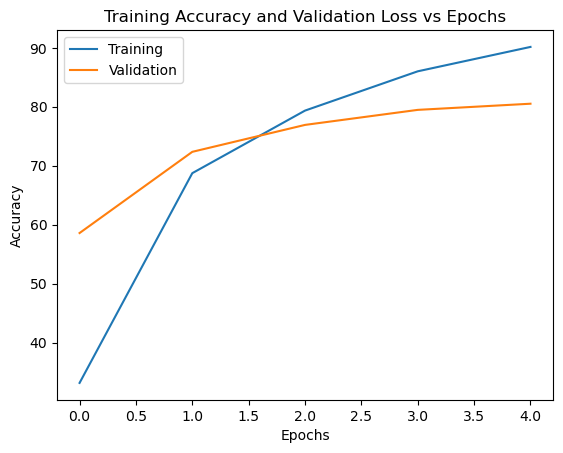

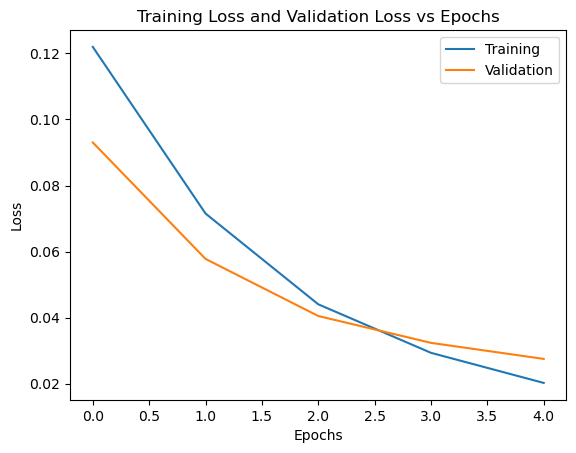

In [30]:
#RESNET50 normal
test_true, test_pred ,train_acc,train_loss,val_acc,val_loss, model = model_pipeline_res(config, trainloader, valloader, testloader, False)
x = range(config["epochs"])
plt.plot(x,train_acc,label="Training")
plt.plot(x,val_acc,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy and Validation Loss vs Epochs")
plt.show()
x = range(config["epochs"])
plt.plot(x,train_loss,label="Training")
plt.plot(x,val_loss,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss and Validation Loss vs Epochs")
plt.show()
filename = '/resnet50'
pickle.dump(model, open(filename, 'wb'))

In [31]:
criterion = nn.CrossEntropyLoss()
#   optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

# and use them to train the model
train_acc,train_loss,val_acc,val_loss = training_res(model, trainloader, criterion, optimizer, config, valloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Loss after 03200 examples: 0.172
Training Accuracy: 93.34375
Loss after 06400 examples: 0.137
Training Accuracy: 93.359375
Loss after 09600 examples: 0.217
Training Accuracy: 93.63541666666667
Loss after 12800 examples: 0.118
Training Accuracy: 93.78125


 20%|██        | 1/5 [03:46<15:07, 226.93s/it]


VALIDATION ACC 81.87560738581146
VALIDATION LOSS 0.01901356503367424

Loss after 03200 examples: 0.052
Training Accuracy: 97.21875
Loss after 06400 examples: 0.025
Training Accuracy: 96.796875
Loss after 09600 examples: 0.039
Training Accuracy: 96.63541666666667
Loss after 12800 examples: 0.128
Training Accuracy: 96.390625


 40%|████      | 2/5 [07:39<11:30, 230.07s/it]


VALIDATION ACC 82.04567541302235
VALIDATION LOSS 0.02016139918516514

Loss after 03200 examples: 0.043
Training Accuracy: 97.9375
Loss after 06400 examples: 0.036
Training Accuracy: 97.90625
Loss after 09600 examples: 0.021
Training Accuracy: 97.82291666666667
Loss after 12800 examples: 0.170
Training Accuracy: 97.859375


 60%|██████    | 3/5 [11:34<07:44, 232.38s/it]


VALIDATION ACC 82.6287657920311
VALIDATION LOSS 0.020481321399540897

Loss after 03200 examples: 0.040
Training Accuracy: 98.625
Loss after 06400 examples: 0.039
Training Accuracy: 98.390625
Loss after 09600 examples: 0.034
Training Accuracy: 98.34375
Loss after 12800 examples: 0.022
Training Accuracy: 98.3984375


 80%|████████  | 4/5 [15:30<03:54, 234.06s/it]


VALIDATION ACC 79.73760932944606
VALIDATION LOSS 0.025373687490683312

Loss after 03200 examples: 0.034
Training Accuracy: 99.34375
Loss after 06400 examples: 0.051
Training Accuracy: 99.203125
Loss after 09600 examples: 0.070
Training Accuracy: 98.94791666666667
Loss after 12800 examples: 0.070
Training Accuracy: 98.671875


100%|██████████| 5/5 [19:25<00:00, 233.08s/it]


VALIDATION ACC 81.75413022351798
VALIDATION LOSS 0.022433955830578903

Finished training


In [32]:
test_true, test_pred = test_res(model, testloader)

              precision    recall  f1-score   support

         0.0       0.47      0.70      0.56        10
         1.0       0.85      0.79      0.81        14
         2.0       0.86      0.86      0.86        21
         3.0       0.93      0.82      0.87        17
         4.0       0.82      0.78      0.80        23
         5.0       0.89      0.94      0.91        17
         6.0       1.00      1.00      1.00        18
         7.0       0.62      0.62      0.62        16
         8.0       0.73      0.86      0.79        22
         9.0       0.93      0.93      0.93        27
        10.0       0.88      1.00      0.94        22
        11.0       0.90      1.00      0.95        19
        12.0       0.94      0.94      0.94        16
        13.0       0.78      0.78      0.78        18
        14.0       0.88      0.82      0.85        17
        15.0       0.36      0.45      0.40        11
        16.0       0.55      0.43      0.48        14
        17.0       0.78    

In [33]:
%cd /kaggle/working
filename = 'Resnet50_normal'
pickle.dump(model, open(filename, 'wb'))
from IPython.display import FileLink
FileLink(r'Resnet50_normal')

/kaggle/working


/kaggle/working/Resnet50_normal

In [40]:
criterion = nn.CrossEntropyLoss()
#   optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

# and use them to train the model
train_acc,train_loss,val_acc,val_loss = training_res(model, trainloader, criterion, optimizer, config, valloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Loss after 03200 examples: 0.263
Training Accuracy: 92.21875
Loss after 06400 examples: 0.367
Training Accuracy: 91.671875
Loss after 09600 examples: 0.482
Training Accuracy: 91.41666666666667
Loss after 12800 examples: 0.170
Training Accuracy: 91.4140625


 20%|██        | 1/5 [03:03<12:14, 183.62s/it]


VALIDATION ACC 70.48104956268222
VALIDATION LOSS 0.032682605732170786

Loss after 03200 examples: 0.192
Training Accuracy: 94.625
Loss after 06400 examples: 0.101
Training Accuracy: 94.8125
Loss after 09600 examples: 0.315
Training Accuracy: 94.92708333333333
Loss after 12800 examples: 0.266
Training Accuracy: 94.75


 40%|████      | 2/5 [06:07<09:11, 183.75s/it]


VALIDATION ACC 70.6511175898931
VALIDATION LOSS 0.032945523565260385

Loss after 03200 examples: 0.104
Training Accuracy: 97.59375
Loss after 06400 examples: 0.042
Training Accuracy: 96.984375
Loss after 09600 examples: 0.152
Training Accuracy: 96.79166666666667
Loss after 12800 examples: 0.246
Training Accuracy: 96.703125


 60%|██████    | 3/5 [09:10<06:06, 183.41s/it]


VALIDATION ACC 70.6025267249757
VALIDATION LOSS 0.03327867362659109

Loss after 03200 examples: 0.044
Training Accuracy: 97.6875
Loss after 06400 examples: 0.039
Training Accuracy: 97.875
Loss after 09600 examples: 0.212
Training Accuracy: 97.90625
Loss after 12800 examples: 0.038
Training Accuracy: 97.609375


 80%|████████  | 4/5 [12:13<03:03, 183.42s/it]


VALIDATION ACC 73.68804664723032
VALIDATION LOSS 0.031943770145419964

Loss after 03200 examples: 0.021
Training Accuracy: 99.46875
Loss after 06400 examples: 0.061
Training Accuracy: 98.765625
Loss after 09600 examples: 0.061
Training Accuracy: 98.5
Loss after 12800 examples: 0.067
Training Accuracy: 98.1796875


100%|██████████| 5/5 [15:17<00:00, 183.44s/it]


VALIDATION ACC 72.8862973760933
VALIDATION LOSS 0.03426640265710847

Finished training


In [41]:
test_true, test_pred = test_res(model, testloader)

              precision    recall  f1-score   support

         0.0       0.35      0.70      0.47        10
         1.0       0.69      0.64      0.67        14
         2.0       0.58      0.90      0.70        21
         3.0       0.61      0.82      0.70        17
         4.0       0.59      0.74      0.65        23
         5.0       0.88      0.88      0.88        17
         6.0       0.70      0.89      0.78        18
         7.0       0.67      0.62      0.65        16
         8.0       0.55      0.77      0.64        22
         9.0       0.96      0.89      0.92        27
        10.0       0.80      0.73      0.76        22
        11.0       0.61      0.74      0.67        19
        12.0       0.70      0.88      0.78        16
        13.0       1.00      0.67      0.80        18
        14.0       0.78      0.82      0.80        17
        15.0       0.33      0.45      0.38        11
        16.0       0.70      0.50      0.58        14
        17.0       0.77    

In [42]:
%cd /kaggle/working
filename = 'MobileNet_normal'
pickle.dump(model, open(filename, 'wb'))
from IPython.display import FileLink
FileLink(r'MobileNet_normal')

/kaggle/working


/kaggle/working/MobileNet_normal

  0%|          | 0/10 [00:00<?, ?it/s]

Loss after 03200 examples: 4.328
Training Accuracy: 5.4375
Loss after 06400 examples: 3.925
Training Accuracy: 15.46875
Loss after 09600 examples: 3.668
Training Accuracy: 23.833333333333332
Loss after 12800 examples: 3.322
Training Accuracy: 30.21875


 10%|█         | 1/10 [06:36<59:25, 396.21s/it]


VALIDATION ACC 58.74635568513119
VALIDATION LOSS 0.09360328962550335

Loss after 03200 examples: 2.804
Training Accuracy: 62.5
Loss after 06400 examples: 2.465
Training Accuracy: 64.203125
Loss after 09600 examples: 2.205
Training Accuracy: 65.90625
Loss after 12800 examples: 1.901
Training Accuracy: 67.2109375


 20%|██        | 2/10 [10:39<40:48, 306.00s/it]


VALIDATION ACC 72.23032069970846
VALIDATION LOSS 0.05885906860710233

Loss after 03200 examples: 1.659
Training Accuracy: 77.25
Loss after 06400 examples: 1.466
Training Accuracy: 78.046875
Loss after 09600 examples: 1.268
Training Accuracy: 78.5
Loss after 12800 examples: 1.345
Training Accuracy: 78.9375


 30%|███       | 3/10 [14:40<32:14, 276.37s/it]


VALIDATION ACC 76.31195335276968
VALIDATION LOSS 0.04172303442878556

Loss after 03200 examples: 0.727
Training Accuracy: 85.53125
Loss after 06400 examples: 0.974
Training Accuracy: 85.6875
Loss after 09600 examples: 1.128
Training Accuracy: 85.39583333333333
Loss after 12800 examples: 0.828
Training Accuracy: 85.34375


 40%|████      | 4/10 [18:40<26:12, 262.11s/it]


VALIDATION ACC 78.1827016520894
VALIDATION LOSS 0.03346488008635848

Loss after 03200 examples: 0.862
Training Accuracy: 89.03125
Loss after 06400 examples: 0.768
Training Accuracy: 89.453125
Loss after 09600 examples: 0.648
Training Accuracy: 89.54166666666667
Loss after 12800 examples: 0.604
Training Accuracy: 89.7578125


 50%|█████     | 5/10 [23:14<22:12, 266.47s/it]


VALIDATION ACC 80.05344995140914
VALIDATION LOSS 0.02820630769803758

Loss after 03200 examples: 0.449
Training Accuracy: 93.375
Loss after 06400 examples: 0.639
Training Accuracy: 93.3125
Loss after 09600 examples: 0.451
Training Accuracy: 93.10416666666667
Loss after 12800 examples: 0.494
Training Accuracy: 92.8828125


 60%|██████    | 6/10 [27:15<17:11, 257.89s/it]


VALIDATION ACC 80.22351797862002
VALIDATION LOSS 0.02575353333912971

Loss after 03200 examples: 0.322
Training Accuracy: 94.96875
Loss after 06400 examples: 0.223
Training Accuracy: 95.0
Loss after 09600 examples: 0.343
Training Accuracy: 95.0625
Loss after 12800 examples: 0.236
Training Accuracy: 95.078125


 70%|███████   | 7/10 [31:23<12:43, 254.39s/it]


VALIDATION ACC 80.02915451895043
VALIDATION LOSS 0.02423902198426114

Loss after 03200 examples: 0.295
Training Accuracy: 96.71875
Loss after 06400 examples: 0.377
Training Accuracy: 96.703125
Loss after 09600 examples: 0.204
Training Accuracy: 96.75
Loss after 12800 examples: 0.385
Training Accuracy: 96.7578125


 80%|████████  | 8/10 [35:24<08:20, 250.37s/it]


VALIDATION ACC 80.4907677356657
VALIDATION LOSS 0.02309933907928921

Loss after 03200 examples: 0.149
Training Accuracy: 98.25
Loss after 06400 examples: 0.233
Training Accuracy: 98.140625
Loss after 09600 examples: 0.164
Training Accuracy: 98.10416666666667
Loss after 12800 examples: 0.156
Training Accuracy: 97.9765625


 90%|█████████ | 9/10 [39:26<04:07, 247.51s/it]


VALIDATION ACC 80.70942662779397
VALIDATION LOSS 0.022817312353322294

Loss after 03200 examples: 0.095
Training Accuracy: 98.8125
Loss after 06400 examples: 0.209
Training Accuracy: 98.640625
Loss after 09600 examples: 0.172
Training Accuracy: 98.64583333333333
Loss after 12800 examples: 0.107
Training Accuracy: 98.671875


100%|██████████| 10/10 [43:27<00:00, 260.73s/it]


VALIDATION ACC 81.85131195335276
VALIDATION LOSS 0.021977245409414533

Finished training


              precision    recall  f1-score   support

         0.0       0.67      0.60      0.63        10
         1.0       0.73      0.79      0.76        14
         2.0       0.83      0.90      0.86        21
         3.0       0.93      0.76      0.84        17
         4.0       0.78      0.78      0.78        23
         5.0       0.84      0.94      0.89        17
         6.0       1.00      1.00      1.00        18
         7.0       0.75      0.56      0.64        16
         8.0       0.79      0.68      0.73        22
         9.0       0.92      0.89      0.91        27
        10.0       0.83      0.86      0.84        22
        11.0       0.85      0.89      0.87        19
        12.0       0.88      0.94      0.91        16
        13.0       0.88      0.78      0.82        18
        14.0       0.94      0.88      0.91        17
        15.0       0.25      0.36      0.30        11
        16.0       0.55      0.43      0.48        14
        17.0       0.82    

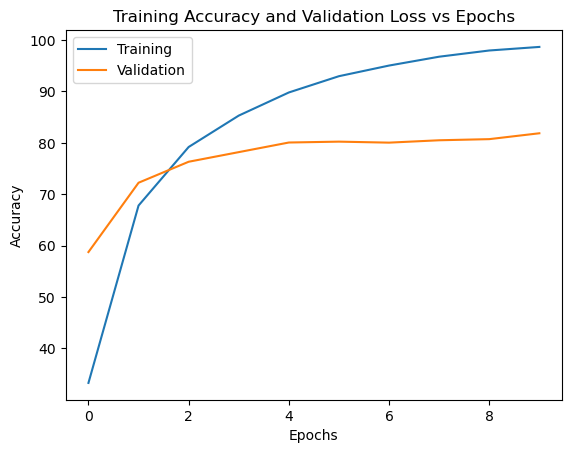

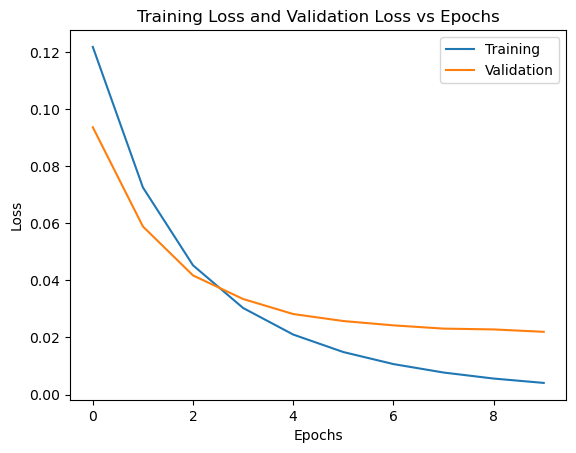

In [32]:
#ResNet50 bounded
test_true, test_pred ,train_acc,train_loss,val_acc,val_loss, model = model_pipeline_res(config, trainloader, valloader, testloader, False)
x = range(config["epochs"])
plt.plot(x,train_acc,label="Training")
plt.plot(x,val_acc,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy and Validation Loss vs Epochs")
plt.show()
x = range(config["epochs"])
plt.plot(x,train_loss,label="Training")
plt.plot(x,val_loss,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss and Validation Loss vs Epochs")
plt.show()
filename = '/resnet50'
pickle.dump(model, open(filename, 'wb'))

In [33]:
%cd /kaggle/working
filename = 'ResNet50_bounded'
pickle.dump(model, open(filename, 'wb'))
from IPython.display import FileLink
FileLink(r'ResNet50_bounded')

/kaggle/working


/kaggle/working/ResNet50_bounded

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Loss after 03200 examples: 4.638
Training Accuracy: 1.59375
Loss after 06400 examples: 3.566
Training Accuracy: 7.046875
Loss after 09600 examples: 2.741
Training Accuracy: 14.322916666666666
Loss after 12800 examples: 2.363
Training Accuracy: 21.2734375


 10%|█         | 1/10 [05:40<51:05, 340.60s/it]


VALIDATION ACC 50.48590864917396
VALIDATION LOSS 0.057528641932907326

Loss after 03200 examples: 1.782
Training Accuracy: 58.28125
Loss after 06400 examples: 1.583
Training Accuracy: 60.265625
Loss after 09600 examples: 1.306
Training Accuracy: 61.510416666666664
Loss after 12800 examples: 1.125
Training Accuracy: 62.5625


 20%|██        | 2/10 [09:03<34:36, 259.58s/it]


VALIDATION ACC 63.28960155490768
VALIDATION LOSS 0.04043274454634901

Loss after 03200 examples: 0.982
Training Accuracy: 75.25
Loss after 06400 examples: 0.886
Training Accuracy: 75.109375
Loss after 09600 examples: 0.856
Training Accuracy: 75.26041666666667
Loss after 12800 examples: 0.823
Training Accuracy: 75.6875


 30%|███       | 3/10 [12:26<27:17, 233.92s/it]


VALIDATION ACC 67.05539358600583
VALIDATION LOSS 0.0354180018715307

Loss after 03200 examples: 0.551
Training Accuracy: 82.75
Loss after 06400 examples: 0.682
Training Accuracy: 83.546875
Loss after 09600 examples: 0.441
Training Accuracy: 83.4375
Loss after 12800 examples: 0.815
Training Accuracy: 83.125


 40%|████      | 4/10 [15:52<22:15, 222.65s/it]


VALIDATION ACC 68.14868804664724
VALIDATION LOSS 0.034201283337307625

Loss after 06400 examples: 0.133
Training Accuracy: 97.34375
Loss after 09600 examples: 0.093
Training Accuracy: 97.30208333333333
Loss after 12800 examples: 0.268
Training Accuracy: 97.1796875


 80%|████████  | 8/10 [29:20<06:52, 206.28s/it]


VALIDATION ACC 69.87366375121478
VALIDATION LOSS 0.03275897816562096

Loss after 03200 examples: 0.051
Training Accuracy: 97.71875
Loss after 06400 examples: 0.117
Training Accuracy: 97.84375
Loss after 09600 examples: 0.124
Training Accuracy: 97.92708333333333
Loss after 12800 examples: 0.089
Training Accuracy: 97.9375


 90%|█████████ | 9/10 [32:45<03:25, 205.67s/it]


VALIDATION ACC 69.87366375121478
VALIDATION LOSS 0.033649984272911895

Loss after 03200 examples: 0.074
Training Accuracy: 98.90625
Loss after 06400 examples: 0.149
Training Accuracy: 98.65625
Loss after 09600 examples: 0.073
Training Accuracy: 98.65625
Loss after 12800 examples: 0.079
Training Accuracy: 98.65625


100%|██████████| 10/10 [36:09<00:00, 216.96s/it]


VALIDATION ACC 70.50534499514092
VALIDATION LOSS 0.033755258775603085

Finished training


              precision    recall  f1-score   support

         0.0       0.35      0.60      0.44        10
         1.0       0.80      0.86      0.83        14
         2.0       0.76      0.76      0.76        21
         3.0       1.00      0.82      0.90        17
         4.0       0.66      0.83      0.73        23
         5.0       0.88      0.82      0.85        17
         6.0       0.94      0.89      0.91        18
         7.0       0.75      0.56      0.64        16
         8.0       0.52      0.64      0.57        22
         9.0       0.89      0.89      0.89        27
        10.0       0.77      0.91      0.83        22
        11.0       0.73      0.84      0.78        19
        12.0       0.76      0.81      0.79        16
        13.0       0.83      0.83      0.83        18
        14.0       0.88      0.82      0.85        17
        15.0       0.23      0.27      0.25        11
        16.0       0.58      0.50      0.54        14
        17.0       0.77    

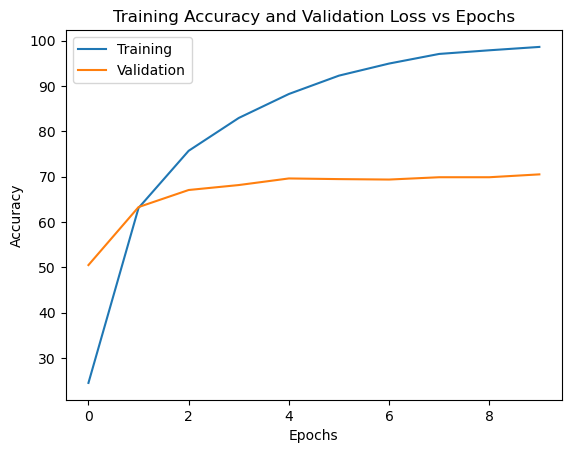

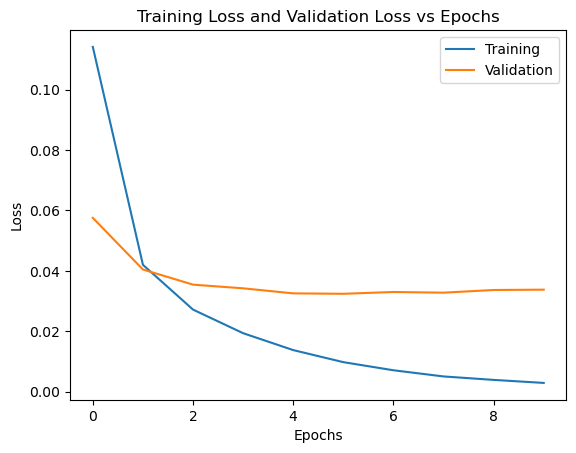

In [37]:
#MobileNet bounded
test_true, test_pred ,train_acc,train_loss,val_acc,val_loss, model = model_pipeline_res(config, trainloader, valloader, testloader, False)
x = range(config["epochs"])
plt.plot(x,train_acc,label="Training")
plt.plot(x,val_acc,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy and Validation Loss vs Epochs")
plt.show()
x = range(config["epochs"])
plt.plot(x,train_loss,label="Training")
plt.plot(x,val_loss,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss and Validation Loss vs Epochs")
plt.show()
filename = '/resnet50'
pickle.dump(model, open(filename, 'wb'))

In [38]:
%cd /kaggle/working
filename = 'MobileNet_bounded'
pickle.dump(model, open(filename, 'wb'))
from IPython.display import FileLink
FileLink(r'MobileNet_bounded')

/kaggle/working


/kaggle/working/MobileNet_bounded

In [29]:
class Ensemble(nn.Module):

    def __init__(self, dropout=0.3):

        super(Ensemble, self).__init__()

        self.vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
        self.vit.classifier = nn.Linear(768,120)
        
        self.res = models.resnet50(pretrained=True)
        self.res.fc = nn.Linear(2048, 120)
        
        self.mobile = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=models.mobilenetv2.MobileNet_V2_Weights.DEFAULT)
        self.mobile.classifier[1] = nn.Linear(1280,120)
        

    def forward(self, images):
            
        pooled_output_vit = self.vit(images).logits
        pooled_output_mobile = self.mobile(images).data
        pooled_output_res = self.res(images).data
        
        pooled_output = (pooled_output_vit + pooled_output_mobile + pooled_output_res)/3

        return pooled_output

In [30]:
def training_en(model,loader,criterion,optimizer,config,valloader):
  train_acc_arr = []
  train_loss_arr = []
  val_acc_arr = []
  val_loss_arr = []
  y_pred = []
  y_true = []

  for epoch in tqdm(range(config['epochs'])):

    example_ct = 0
    batch_ct = 0
    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data

        labels_without_one_hot = labels.float().to(device)
        labels = F.one_hot(labels, num_classes=120)
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels_without_one_hot).sum().item()

        loss = criterion(outputs, torch.max(labels, 1)[1])
        optimizer.zero_grad()
        # loss.requires_grad = True
        loss.backward()
        optimizer.step()

        example_ct +=  len(inputs)
        batch_ct += 1
        running_loss += loss.item()

        if ((batch_ct) % 100) == 0:
            print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")
            print(f"Training Accuracy: {100*correct/total}")

    # train_acc, train_loss = accuracy_test(model,trainloader,criterion)
    train_acc = 100*correct/total
    train_loss = running_loss/total
    val_acc,val_loss = accuracy_test_en(model,valloader,criterion)
    print()
    print("VALIDATION ACC",val_acc)
    print("VALIDATION LOSS",val_loss)
    print()
    train_acc_arr.append(train_acc)
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    val_loss_arr.append(val_loss)

  print("Finished training")
  return train_acc_arr,train_loss_arr,val_acc_arr,val_loss_arr

In [31]:
def test_en(model, loader):
    model.eval()

    correct, total ,incorrect= 0, 0,0

    y_pred = []
    y_true = []

    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    with torch.no_grad():
        for data in loader:
          images, labels = data

          saved_images = images

          images = images.float().to(device)
          # images = torch.transpose(images,-1,1)
          labels = labels.float().to(device)
        
#           inputs = image_processor(images, return_tensors="pt")
            
          outputs = model(images)

          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          correct += (predicted == labels).sum().item()

          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())
          

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
    print(classification_report(y_true, y_pred))
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Accuracy of the model on the set of " + f"test images: {correct / total:%}")

    return y_true, y_pred

In [32]:
def accuracy_test_en(model,loader,criterion):
  correct = 0
  total = 0
  tot_loss = 0
  with torch.no_grad():
      for data in loader:
          images, labels = data
                    
          images = images.float().to(device)
          # labels = labels.float().to(device)

          le = preprocessing.LabelEncoder()
          targets = le.fit_transform(labels)
          targets = torch.as_tensor(targets) 
            
          outputs = model(images)
          
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          labels = labels.to(device)
          correct += (predicted == labels).sum().item()
          
          labels = labels.to(torch.int64)
          labels = F.one_hot(labels, num_classes=120).to(torch.float64)

          loss = criterion(outputs, torch.max(labels, 1)[1])

          tot_loss += loss.item()


  Accuracy = 100 * correct / total
  Loss = tot_loss / total
  return Accuracy,Loss

In [33]:
model = Ensemble().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

# and use them to train the model
train_acc,train_loss,val_acc,val_loss = training_en(model, trainloader, criterion, optimizer, config, valloader)


# and test its final performance
test_true, test_pred = test_en(model, testloader)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss after 03200 examples: 4.620
Training Accuracy: 2.03125
Loss after 06400 examples: 4.441
Training Accuracy: 5.65625
Loss after 09600 examples: 4.337
Training Accuracy: 11.822916666666666
Loss after 12800 examples: 4.217
Training Accuracy: 18.6328125


 20%|██        | 1/5 [10:24<41:39, 624.92s/it]


VALIDATION ACC 51.50631681243926
VALIDATION LOSS 0.12741668300795486

Loss after 03200 examples: 3.855
Training Accuracy: 58.5625
Loss after 06400 examples: 3.745
Training Accuracy: 61.9375
Loss after 09600 examples: 3.598
Training Accuracy: 64.55208333333333
Loss after 12800 examples: 3.369
Training Accuracy: 66.4296875


 40%|████      | 2/5 [18:31<27:10, 543.44s/it]


VALIDATION ACC 73.63945578231292
VALIDATION LOSS 0.10574922489818725

Loss after 03200 examples: 2.959
Training Accuracy: 78.46875
Loss after 06400 examples: 2.952
Training Accuracy: 79.390625
Loss after 09600 examples: 2.738
Training Accuracy: 79.72916666666667
Loss after 12800 examples: 2.704
Training Accuracy: 80.078125


 60%|██████    | 3/5 [26:35<17:12, 516.40s/it]


VALIDATION ACC 79.03304178814383
VALIDATION LOSS 0.08822569775280151

Loss after 03200 examples: 2.249
Training Accuracy: 84.65625
Loss after 06400 examples: 2.271
Training Accuracy: 86.0
Loss after 09600 examples: 2.301
Training Accuracy: 86.08333333333333
Loss after 12800 examples: 2.054
Training Accuracy: 86.109375


 80%|████████  | 4/5 [34:43<08:25, 505.14s/it]


VALIDATION ACC 81.58406219630709
VALIDATION LOSS 0.0738823110902043

Loss after 03200 examples: 2.036
Training Accuracy: 89.15625
Loss after 06400 examples: 1.807
Training Accuracy: 89.640625
Loss after 09600 examples: 1.815
Training Accuracy: 89.73958333333333
Loss after 12800 examples: 1.735
Training Accuracy: 89.734375


100%|██████████| 5/5 [42:52<00:00, 514.51s/it]


VALIDATION ACC 83.33333333333333
VALIDATION LOSS 0.06189736248916278

Finished training


              precision    recall  f1-score   support

         0.0       0.62      0.80      0.70        10
         1.0       0.92      0.86      0.89        14
         2.0       0.86      0.90      0.88        21
         3.0       1.00      0.65      0.79        17
         4.0       0.75      0.91      0.82        23
         5.0       0.94      1.00      0.97        17
         6.0       0.94      0.94      0.94        18
         7.0       1.00      0.75      0.86        16
         8.0       0.62      0.95      0.75        22
         9.0       0.96      1.00      0.98        27
        10.0       0.91      0.91      0.91        22
        11.0       0.67      0.95      0.78        19
        12.0       0.83      0.94      0.88        16
        13.0       0.88      0.78      0.82        18
        14.0       1.00      0.76      0.87        17
        15.0       0.55      0.55      0.55        11
        16.0       0.83      0.36      0.50        14
        17.0       0.91    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
train_acc,train_loss,val_acc,val_loss = training_en(model, trainloader, criterion, optimizer, config, valloader)


# and test its final performance
test_true, test_pred = test_en(model, testloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Loss after 03200 examples: 1.389
Training Accuracy: 92.65625
Loss after 06400 examples: 1.344
Training Accuracy: 92.484375
Loss after 09600 examples: 1.456
Training Accuracy: 92.71875
Loss after 12800 examples: 1.269
Training Accuracy: 92.8984375


 20%|██        | 1/5 [08:19<33:19, 499.79s/it]


VALIDATION ACC 84.42662779397473
VALIDATION LOSS 0.052147886785520174

Loss after 03200 examples: 1.170
Training Accuracy: 95.3125
Loss after 06400 examples: 1.035
Training Accuracy: 95.0
Loss after 09600 examples: 0.968
Training Accuracy: 94.85416666666667
Loss after 12800 examples: 0.961
Training Accuracy: 94.8671875


 40%|████      | 2/5 [16:34<24:50, 496.97s/it]


VALIDATION ACC 84.7181729834791
VALIDATION LOSS 0.04478498210133107

Loss after 03200 examples: 0.835
Training Accuracy: 96.6875
Loss after 06400 examples: 0.754
Training Accuracy: 96.703125
Loss after 09600 examples: 0.739
Training Accuracy: 96.65625
Loss after 12800 examples: 0.741
Training Accuracy: 96.65625


 60%|██████    | 3/5 [24:53<16:35, 497.72s/it]


VALIDATION ACC 84.40233236151603
VALIDATION LOSS 0.03929313817455192

Loss after 03200 examples: 0.519
Training Accuracy: 97.75
Loss after 06400 examples: 0.527
Training Accuracy: 97.8125
Loss after 09600 examples: 0.529
Training Accuracy: 97.85416666666667
Loss after 12800 examples: 0.527
Training Accuracy: 97.78125


 80%|████████  | 4/5 [33:10<08:17, 497.55s/it]


VALIDATION ACC 84.13508260447036
VALIDATION LOSS 0.03486671518132568

Loss after 03200 examples: 0.472
Training Accuracy: 98.8125
Loss after 06400 examples: 0.517
Training Accuracy: 98.703125
Loss after 12800 examples: 0.370
Training Accuracy: 98.5703125


100%|██████████| 5/5 [41:25<00:00, 497.18s/it]


VALIDATION ACC 84.01360544217687
VALIDATION LOSS 0.0314576920371709

Finished training


              precision    recall  f1-score   support

         0.0       0.62      0.80      0.70        10
         1.0       0.92      0.86      0.89        14
         2.0       0.89      0.76      0.82        21
         3.0       1.00      0.82      0.90        17
         4.0       0.80      0.87      0.83        23
         5.0       0.94      1.00      0.97        17
         6.0       1.00      0.94      0.97        18
         7.0       1.00      0.81      0.90        16
         8.0       0.62      0.95      0.75        22
         9.0       1.00      1.00      1.00        27
        10.0       0.90      0.86      0.88        22
        11.0       0.77      0.89      0.83        19
        12.0       0.83      0.94      0.88        16
        13.0       0.88      0.78      0.82        18
        14.0       1.00      0.82      0.90        17
        15.0       0.46      0.55      0.50        11
        16.0       0.67      0.43      0.52        14
        17.0       0.86    

In [35]:
%cd /kaggle/working
filename = 'Ensemble_bounded'
pickle.dump(model, open(filename, 'wb'))
from IPython.display import FileLink
FileLink(r'Ensemble_bounded')

/kaggle/working


/kaggle/working/Ensemble_bounded

# **Virtal Environment for testing**

In [1]:
import os
import torch
import pickle
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import cv2
from torchvision import models
from sklearn import preprocessing
from tqdm import tqdm
import random
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
from transformers import AutoImageProcessor, ViTForImageClassification
import torch
from datasets import load_dataset

In [2]:
class VITMODEL(nn.Module):

    def __init__(self, dropout=0.3):

        super(VITMODEL, self).__init__()

        self.vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
#         self.dropout = nn.Dropout(dropout)
#         self.linear = nn.Linear(768, 120)
        self.vit.classifier = nn.Linear(768,120)
        

    def forward(self, images):
            
        pooled_output = self.vit(images)
#         print(pooled_output.shape)
#         print(pooled_output)
#         pooled_output = pooled_output.logits
#         print(pooled_output)
#         dropout_output = self.dropout(pooled_output)
#         linear_output = self.linear(dropout_output)

        return pooled_output

In [3]:
class RESNET50(nn.Module):

    def __init__(self, dropout=0.3):

        super(RESNET50, self).__init__()

        self.mobile = models.resnet50(pretrained=True)
        self.mobile.fc = nn.Linear(2048, 120)

    def forward(self, images):

        pooled_output = self.mobile(images)

        return pooled_output

In [23]:
class MobileNetV2(nn.Module):

    def __init__(self, dropout=0.3):

        super(MobileNetV2, self).__init__()

        self.mobile = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=models.mobilenetv2.MobileNet_V2_Weights.DEFAULT)
        self.mobile.classifier[1] = nn.Linear(1280,120)
#         self.dropout = nn.Dropout(dropout)
#         self.linear = nn.Linear(1000, 120)
#         self.soft = nn.Softmax()

    def forward(self, images):

        pooled_output = self.mobile(images)

#         dropout_output = self.dropout(pooled_output)
#         linear_output = self.linear(dropout_output)
#         final_layer = self.soft(pooled_output)

        return pooled_output

In [27]:
class Ensemble(nn.Module):

    def __init__(self, dropout=0.3):

        super(Ensemble, self).__init__()

        self.vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
        self.vit.classifier = nn.Linear(768,120)
        
        self.res = models.resnet50(pretrained=True)
        self.res.fc = nn.Linear(2048, 120)
        
        self.mobile = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=models.mobilenetv2.MobileNet_V2_Weights.DEFAULT)
        self.mobile.classifier[1] = nn.Linear(1280,120)
        

    def forward(self, images):
            
        pooled_output_vit = self.vit(images).logits
        pooled_output_mobile = self.mobile(images).data
        pooled_output_res = self.res(images).data
        
        pooled_output = (pooled_output_vit + pooled_output_mobile + pooled_output_res)/3

        return pooled_output

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
dataset = datasets.ImageFolder('/kaggle/input/stanford-dogs-dataset/images/Images')
dataset_len = len(dataset)

In [6]:
def load_text_file(path):
        with open(path, 'r') as f:
            text = f.read()
        return text

In [7]:
annotation = datasets.DatasetFolder('/kaggle/input/stanford-dogs-dataset/annotations/Annotation', loader=load_text_file, extensions=('',))

In [8]:
train_size = int(dataset_len*0.7)
test_size = int(dataset_len*0.1)
val_size = int(dataset_len*0.2)

In [9]:
def train_test_val_split():
  g = torch.Generator()
  g.manual_seed(42)
  indices = list(range(dataset_len))
  np.random.seed(11)
  np.random.shuffle(indices)

  test_index = indices[:test_size]
  train_index = indices[test_size:test_size+train_size]
  val_index = indices[-val_size:]

  train_sampler=SubsetRandomSampler(train_index, generator=g)
  val_sampler=SubsetRandomSampler(val_index, generator=g)
  test_sampler=SubsetRandomSampler(test_index, generator=g)

  return train_sampler,val_sampler,test_sampler,indices, train_index

In [10]:
train_sampler,val_sampler,test_sampler,indices, train_index = train_test_val_split()

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset, annotation, train_index, transform=None, normalize=None):
        self.dataset = dataset
        self.annotation = annotation
        self.dataset_len = len(dataset)
        self.transform = transform
        self.normalize = normalize
        self.train_index = train_index
        # self.dataset = np.transpose(dataset[0], (1, 2, 0))        

    def __len__(self):
        return self.dataset_len
    
    def load_text_file(path):
        with open(path, 'r') as f:
            text = f.read()
        return text

    def __getitem__(self, idx):
        
        image, index = self.dataset[idx]
        w,h = image.size
        
        if (idx in self.train_index):
            text = annotation[idx][0]

            xml_root = ET.fromstring(text)
            
            width = int(xml_root.find('size/width').text)
            height = int(xml_root.find('size/height').text)
            xmin = int(xml_root.find('object/bndbox/xmin').text)
            xmax = int(xml_root.find('object/bndbox/xmax').text)
            ymin = int(xml_root.find('object/bndbox/ymin').text)
            ymax = int(xml_root.find('object/bndbox/ymax').text)
            
            bbox = (xmin, ymin, xmax, ymax)

            annotated_image = Image.new("RGB", (width, height), color=(255, 255, 255))

            annotated_image.paste(image, (0, 0))

            draw = ImageDraw.Draw(annotated_image)
            thickness = 5
            draw.rectangle(bbox, outline="red", width=thickness)
            
            image = annotated_image
            plt.imshow(image)
            
        
        if w < h:
            resized_image = image.resize((224, int(224 * h / w)))
        else:
            resized_image = image.resize((int(224 * w / h), 224))
        w,h = resized_image.size
        image = resized_image.crop((w/2  - 112, h/2 - 112, w/2 + 112, h/2 + 112))
        if self.transform:
            image = self.transform(image)
            image = image.to(torch.float32)
            image = image/255
            image = self.normalize(image)

        label = index

        return image, label

In [12]:
normalize = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
 ])

In [13]:
transform = transforms.Compose([
    transforms.PILToTensor(),
#     transforms.Resize((224, 224)), 
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomRotation(degrees = (0,20)),
    # transforms.GaussianBlur(5),
])

In [14]:
ImageDataset = CustomImageDataset(dataset,annotation,train_index, transform, normalize)

In [18]:
batch_size=32
trainloader = torch.utils.data.DataLoader(ImageDataset, sampler = train_sampler, batch_size=batch_size)
valloader = torch.utils.data.DataLoader(ImageDataset, sampler = val_sampler, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(ImageDataset, sampler = test_sampler, batch_size=batch_size)

In [19]:
def test_vit(model, loader):
    model.eval()

    correct, total ,incorrect= 0, 0,0

    y_pred = []
    y_true = []

    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    with torch.no_grad():
        for data in loader:
          images, labels = data

          saved_images = images

          images = images.float().to(device)
          # images = torch.transpose(images,-1,1)
          labels = labels.float().to(device)
        
#           inputs = image_processor(images, return_tensors="pt")
            
          outputs = model(images)
#           outputs = outputs.to(device)

          _, predicted = torch.max(outputs.logits, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          correct += (predicted == labels).sum().item()

          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())
          
          # labels = labels.to(torch.int64)
          # labels = F.one_hot(labels, num_classes=10).to(torch.float64)

          # loss = criterion(outputs, labels)
          # loss.requires_grad = True
          # loss.backward()
          # tot_loss += loss.item()

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
    print(classification_report(y_true, y_pred))
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Accuracy of the model on the set of " + f"test images: {correct / total:%}")

    return y_true, y_pred

In [20]:
def test_res(model, loader):
    model.eval()

    correct, total ,incorrect= 0, 0,0

    y_pred = []
    y_true = []

    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    with torch.no_grad():
        for data in loader:
          images, labels = data

          saved_images = images

          images = images.float().to(device)
          # images = torch.transpose(images,-1,1)
          labels = labels.float().to(device)
        
#           inputs = image_processor(images, return_tensors="pt")
            
          outputs = model(images)

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          correct += (predicted == labels).sum().item()

          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())
          

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
    print(classification_report(y_true, y_pred))
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Accuracy of the model on the set of " + f"test images: {correct / total:%}")

    return y_true, y_pred

In [28]:
def test_en(model, loader):
    model.eval()

    correct, total ,incorrect= 0, 0,0

    y_pred = []
    y_true = []

    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    with torch.no_grad():
        for data in loader:
          images, labels = data

          saved_images = images

          images = images.float().to(device)
          # images = torch.transpose(images,-1,1)
          labels = labels.float().to(device)
        
#           inputs = image_processor(images, return_tensors="pt")
            
          outputs = model(images)

          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          correct += (predicted == labels).sum().item()

          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())
          

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
    print(classification_report(y_true, y_pred))
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Accuracy of the model on the set of " + f"test images: {correct / total:%}")

    return y_true, y_pred

In [ ]:
pickled_model = pickle.load(open('/kaggle/input/ensemble-bounded/Ensemble_bounded', 'rb'))
test_true, test_pred = test_en(pickled_model, testloader)